In [1]:
# Importing required Python libraries.

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import os
import seaborn as sns


# Downloading the set of stopwords, which we will be using for preprocessing of our dataset
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


# Using Porterstemmer for stemming, i.e converting the word to its original form.
ps = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Loading Dataset

root_dir = "C:/Users/MSI/Downloads/bbc/bbc"

texts = []
categories = []

for category in os.listdir(root_dir):
    category_dir = os.path.join(root_dir, category)
    if os.path.isdir(category_dir):
        for file_name in os.listdir(category_dir):
            file_path = os.path.join(category_dir, file_name)
            if os.path.isfile(file_path) and file_name.endswith('.txt'):
                with open(file_path, 'r', encoding='unicode-escape') as file:
                    content = file.read()
                texts.append(content)
                categories.append(category)

df = pd.DataFrame({'text': texts, 'category': categories})

df.to_csv('C:/Users/MSI/Downloads/bbc/news_article.csv', index=False)



df = pd.read_csv('C:/Users/MSI/Downloads/bbc/news_article.csv')

In [11]:
df.head()

,text,category
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [12]:
# Preprocessing Data

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

df['processed_text'] = df['text'].apply(preprocess_text)
X= df['processed_text']
y = df["category"]


In [13]:
X.head()

0    ad sale boost time warner profit quarterli pro...
1    dollar gain greenspan speech dollar hit highes...
2    yuko unit buyer face loan claim owner embattl ...
3    high fuel price hit ba profit british airway b...
4    pernod takeov talk lift domecq share uk drink ...
Name: processed_text, dtype: object

In [14]:
y.head()

0    business
1    business
2    business
3    business
4    business
Name: category, dtype: object

In [15]:
# Feature Extraction and Selection.

count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()
ngram_vectorizer = CountVectorizer(ngram_range=(2,2))

X_count = count_vectorizer.fit_transform(X)
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_ngrams = ngram_vectorizer.fit_transform(X)

X_combined = pd.concat([pd.DataFrame(X_tfidf.toarray()),pd.DataFrame(X_count.toarray()),pd.DataFrame(X_ngrams.toarray())],axis=1)

selector = SelectKBest(chi2,k=500)
X_selected = selector.fit_transform(X_combined,y)

In [18]:
# Splitting our dataset into Training, Development (Validation) and Test set.

X_train, X_val, y_train, y_val = train_test_split(X_selected,y, test_size=0.3, random_state=23)
X_val , X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=23)


In [19]:
# Training model and using development set for tuning hyperparameters for better accuracy.

model = SVC()


param_grid = {'C' : [0.1,0.5,1,10] , 'gamma' : [0.01,0.1,1,1.5], 'kernel' : ['linear','rbf', 'poly']}

cv = KFold(n_splits=5, shuffle=True, random_state=23)
grid_search = GridSearchCV(estimator = model, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=3)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
val_score = best_model.score(X_val,y_val)

print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.955 total time=   6.6s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.958 total time=   0.0s
[CV 3/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.968 total time=   0.0s
[CV 4/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.958 total time=   0.0s
[CV 5/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.955 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.591 total time=   0.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.543 total time=   0.3s
[CV 3/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.556 total time=   0.3s
[CV 4/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.534 total time=   0.3s
[CV 5/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.673 total time=   0.3s
[CV 1/5] END ....C=0.1, gamma=0.01, kernel=poly;, score=0.668 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=0.01, kernel=poly

In [20]:
# Performing predictions and evaluating models performance based on best_model found during gridsearch.

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\n Accuracy :", accuracy)

print("\n Classification Report :")
print(classification_report(y_test, y_pred))


 Accuracy : 0.9434523809523809

 Classification Report :
               precision    recall  f1-score   support

     business       0.93      0.93      0.93        86
entertainment       0.95      0.97      0.96        63
     politics       0.94      0.90      0.92        67
        sport       0.98      0.98      0.98        64
         tech       0.91      0.95      0.93        56

     accuracy                           0.94       336
    macro avg       0.94      0.94      0.94       336
 weighted avg       0.94      0.94      0.94       336



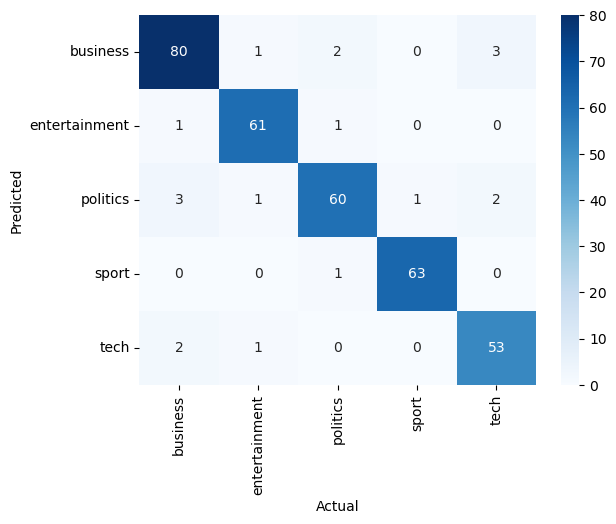

In [23]:
# Confusion matrix which gives clear understanding between the actual and predicted labels.

confusion_mat = confusion_matrix(y_test,y_pred)

sns.heatmap(confusion_mat,annot=True, cmap='Blues',xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()